In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px #visualize interactive image
import ace_tools_open as tools;

In [33]:
market_data = pd.read_csv("data/market_data.csv", index_col='Date', parse_dates=True)
vix_data = pd.read_csv("data/vix_data.csv", index_col='Date', parse_dates=True)
macro_data = pd.read_csv("data/macro_monthly.csv", index_col='Date', parse_dates=True)
RIR_data = pd.read_csv("data/real_interest_rate.csv", index_col='Date', parse_dates=True)
usd_data = pd.read_csv("data/usd_index.csv", index_col='Date', parse_dates=True)
gold_spot_USD = pd.read_csv("data/gold_spot_WGC.csv", index_col='Date', parse_dates=True)


gpr_data = pd.read_excel("data/data_gpr_export.xls", header = 0)
gpr_data = gpr_data.rename(columns={"month": "Date"})
gpr_data = gpr_data.set_index("Date")
gpr_selected = gpr_data[["GPR", "GPRT", "GPRA"]]

gpr_daily = gpr_selected.resample('D').ffill()
macro_daily = macro_data.resample('D').ffill()

In [34]:
datasets = {
    "market": market_data,
    "usd": usd_data,
    "macro": macro_daily,
    "rir": RIR_data,
    "vix": vix_data,
    "gpr": gpr_daily,
    "gold": gold_spot_USD
}

start_dates = []

for name, df in datasets.items():
    df_valid_start = df.apply(lambda col: col.first_valid_index())
    df_start = df_valid_start.max()  
    start_dates.append(df_start)

latest_start = max(start_dates)
print(f"{latest_start.date()}")

2006-01-02


In [35]:
gold_spot_USD = gold_spot_USD.loc[latest_start:]
market_data = market_data.loc[latest_start:]
usd_data = usd_data.loc[latest_start:]
macro_daily = macro_daily.loc[latest_start:]
RIR_data = RIR_data.loc[latest_start:]
vix_data = vix_data.loc[latest_start:]
gpr_daily = gpr_daily.loc[latest_start:]

Resample GPR and macro_data to daily with ffill

In [36]:
combined_data = gold_spot_USD \
    .join(market_data, how='left') \
    .join(usd_data, how='left') \
    .join(macro_daily, how='left') \
    .join(RIR_data, how='left') \
    .join(vix_data, how='left') \
    .join(gpr_daily, how='left')


tools.display_dataframe_to_user(name="Combined dataFrame", dataframe=combined_data)
combined_data.to_csv("data/combined_data.csv")

Combined dataFrame


Loading ITables v2.4.2 from the internet... (need help?)


# 1. Understand - Explore data

## Combined Data

In [4]:
df = combined_data.copy()

In [5]:
df.info

<bound method DataFrame.info of             Crude_Oil  Gold_Futures    Gold_ETF  Silver_Fututes      S&P_500  \
Date                                                                           
2006-01-03  63.139999    530.700012   53.119999        9.087000  1268.800049   
2006-01-04  63.419998    533.900024   53.299999        9.102000  1273.459961   
2006-01-05  62.790001    526.299988   52.340000        8.809000  1273.479980   
2006-01-06  64.209999    539.700012   53.720001        9.112000  1285.449951   
2006-01-09  63.500000    549.099976   54.599998        9.222000  1290.150024   
...               ...           ...         ...             ...          ...   
2024-11-22  71.239998   2709.899902  249.839996       31.309000  5969.339844   
2024-11-25  68.940002   2616.800049  242.479996       30.209999  5987.370117   
2024-11-26  68.769997   2620.300049  242.949997       30.388000  6021.629883   
2024-11-27  68.720001   2639.899902  243.490005       30.111000  5998.740234   
2024-11-

Comment:
- All columns are numericals cols

In [6]:
df.columns

Index(['Crude_Oil', 'Gold_Futures', 'Gold_ETF', 'Silver_Fututes', 'S&P_500',
       'NASDAQ', 'USD_Index', 'CPI', 'Fed_Funds_Rate', 'M2_Supply',
       'Unemployment', 'Treasury_Yield_10Y', 'Real_Interest_Rate', '^VIX',
       'GPR', 'GPRT', 'GPRA'],
      dtype='object')

In [29]:
# df.nunique()

In [7]:
df.isnull().sum()

Crude_Oil              4
Gold_Futures           5
Gold_ETF               0
Silver_Fututes         4
S&P_500                0
NASDAQ                 0
USD_Index             61
CPI                    0
Fed_Funds_Rate         0
M2_Supply              0
Unemployment           0
Treasury_Yield_10Y     0
Real_Interest_Rate    35
^VIX                   0
GPR                    0
GPRT                   0
GPRA                   0
dtype: int64

## Gold Spot

In [4]:
gold_spot = pd.read_excel(
    "data/Gold_price_averages_in_a range_of_currencies_since_1978.xlsx",
    sheet_name='Monthly_Avg',
    header=5
)
gold_spot = gold_spot.loc[:, ~gold_spot.columns.str.startswith("Unnamed")]
gold_spot["Date"] = pd.to_datetime(gold_spot["Date"], errors="coerce") 
gold_spot.set_index("Date", inplace=True)
print(gold_spot.columns.tolist())

['USD', 'EUR', 'JPY', 'GBP', 'CAD', 'CHF', 'INR', 'CNY', 'TRY', 'SAR', 'IDR', 'AED', 'THB', 'VND', 'EGP', 'KRW', 'RUB', 'ZAR', 'AUD']


In [10]:
gold_spot.isnull().sum()

USD      0
EUR      0
JPY      1
GBP      0
CAD      1
CHF      1
INR      1
CNY     73
TRY     49
SAR      1
IDR      1
AED      1
THB      1
VND    132
EGP    120
KRW      1
RUB    169
ZAR      1
AUD      1
dtype: int64

In [11]:
gold_spot.describe()

,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
count,569.000000,569.000000,568.000000,569.000000,568.000000,568.000000,568.000000,496.000000,520.000000,568.000000,5.680000e+02,568.000000,568.000000,4.370000e+02,449.000000,5.680000e+02,400.000000,568.000000,568.000000
mean,799.633761,678.210598,99325.684458,543.077985,997.253322,907.011286,44022.345640,5744.604998,6371.255387,2983.963074,8.263982e+06,2942.260964,25614.694511,1.863627e+07,13361.596943,8.798659e+05,50509.960316,8408.641454,1046.322018
std,610.745038,538.403426,76192.909713,479.748257,782.347625,471.401389,52811.914715,4395.808789,17719.000568,2303.240343,1.030856e+07,2242.510622,20949.287101,1.695786e+07,25489.539296,8.219739e+05,59954.589664,11384.910383,860.562782
min,207.830000,129.208100,28312.980370,104.625990,269.548230,378.772810,1852.847000,845.609630,0.083210,754.088370,1.417964e+05,869.396010,4582.177750,1.577365e+06,874.970000,1.111866e+05,148.353480,197.003410,198.596630
25%,355.100000,306.124430,42915.112500,217.932560,458.682720,501.160825,6927.656985,2252.467500,4.910680,1318.378553,7.183258e+05,1304.490970,9691.732638,4.123598e+06,1181.467140,3.055886e+05,7701.481827,996.876285,476.318463
50%,431.280000,380.706050,78104.872740,262.780840,540.229430,762.459850,13666.533900,3452.460000,548.070000,1579.505000,2.893379e+06,1584.290285,13013.080000,1.063084e+07,3599.930000,3.951678e+05,22268.700000,2447.695000,564.665000
75%,1251.850000,1040.920000,134111.395000,858.660000,1478.207500,1224.497500,78140.790000,8473.027500,3053.247500,4707.455000,1.508655e+07,4604.980000,41231.505000,2.972158e+07,10794.640000,1.403668e+06,75953.650000,13560.195000,1520.815000
max,3277.990000,2908.780000,475098.620000,2453.520000,4546.660000,2721.910000,279596.630000,23650.280000,127251.730000,12295.600000,5.396645e+07,12040.040000,108366.900000,8.510954e+07,164659.820000,4.624691e+06,276997.430000,60732.410000,5109.260000


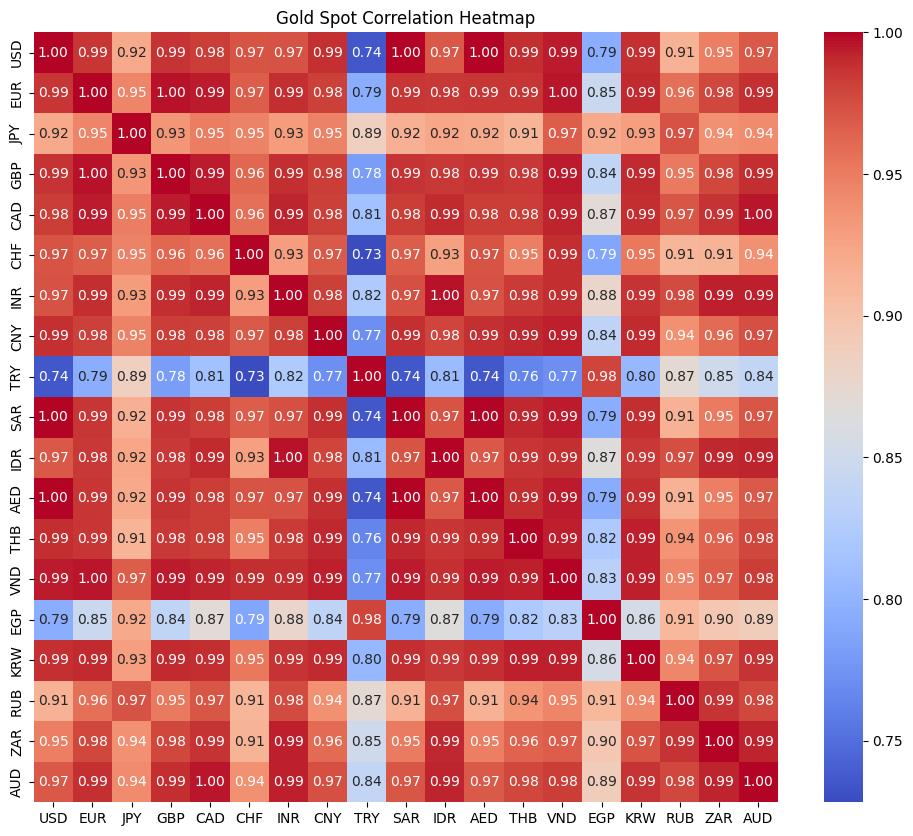

In [5]:
gold_corr = gold_spot.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(gold_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Gold Spot Correlation Heatmap")
plt.show()

## USD_index

In [7]:
full_range = pd.date_range(start=usd_data.index.min(), end=usd_data.index.max(), freq="D")
usd_index_full = usd_data.reindex(full_range)
usd_index_full.index.name = "Date"

In [ ]:
usd_data.isnull().sum()

USD_Index    194
dtype: int64

In [ ]:
usd_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4957 entries, 2006-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   USD_Index  4763 non-null   float64
dtypes: float64(1)
memory usage: 206.5 KB


## 2.Pre-processing